In [0]:
# import standard python libraries
import os
from datetime import datetime
import numpy as np
import pandas as pd


# import the PyTorch deep learning libary
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils import data

# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# import tensorflow
import tensorflow as tf
import timeit

In [0]:
%matplotlib inline

In [0]:
if not os.path.exists('./data'): os.makedirs('./data')  # create data directory
if not os.path.exists('./models'): os.makedirs('./models')  # create trained models directory

#Data Preperation

In [0]:
# download the Fashion MNIST training data
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)

# download the Fashion MNIST evaluation data
eval_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)

In [0]:
train_images = train_dataset.data.numpy().reshape(-1,28*28)
train_labels = train_dataset.targets.data.numpy()

In [136]:
type(train_labels[1])

numpy.int64

In [0]:
# pd.DataFrame(train_images).to_csv("./data/FashionMNIST/processed/train_images.csv",header=None, index=None)
# pd.DataFrame(train_labels).to_csv("./data/FashionMNIST/processed/train_labels.csv",header=None, index=None)

In [0]:
tensor_train_images = torch.Tensor(train_images)
tensor_train_labels = torch.Tensor(train_labels)

reshaped_train_dataset = data.TensorDataset(tensor_train_images, tensor_train_labels)

In [0]:
eval_images = eval_dataset.data.numpy().reshape(-1,28*28)
eval_labels = eval_dataset.targets.data.numpy()

In [0]:
# pd.DataFrame(eval_images).to_csv("./data/FashionMNIST/processed/eval_images.csv",header=None, index=None)
# pd.DataFrame(eval_labels).to_csv("./data/FashionMNIST/processed/eval_labels.csv",header=None, index=None)

In [0]:
tensor_eval_images = torch.Tensor(eval_images)
tensor_eval_labels = torch.Tensor(eval_labels)

reshaped_eval_dataset = data.TensorDataset(tensor_eval_images, tensor_eval_labels)

#Testing if GPU is configured

In [142]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

In [143]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.9762451970000257
GPU (s):
0.18334803499965346
GPU speedup over CPU: 10x


In [0]:
# set gpu enabled flag
use_gpu = True

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

In [145]:
!nvidia-smi

Fri May  8 03:43:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    64W / 149W |   1565MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#Neural Network 1

In [0]:
# implement the MNISTNet network architecture
class MNISTNet(nn.Module):
    
    # define the class constructor
    def __init__(self):
        
        # call super class constructor
        super(MNISTNet, self).__init__()
        
        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear1 = nn.Linear(28*28, 300, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity 
        
        # specify fc layer 2 - in 300, out 150
        self.linear2 = nn.Linear(300, 150, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # specify fc layer 3 - in 150, out 50
        self.linear3 = nn.Linear(150, 50) # the linearity W*x+b
        self.relu3 = nn.ReLU(inplace=True) # the non-linarity
        
        # This may be working better

        # # specify fc layer 2 - in 300, out 150
        # self.linear2 = nn.Linear(300, 100, bias=True) # the linearity W*x+b
        # self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # # specify fc layer 3 - in 150, out 50
        # self.linear3 = nn.Linear(100, 50) # the linearity W*x+b
        # self.relu3 = nn.ReLU(inplace=True) # the non-linarity

        # specify fc layer 3 - in 50, out 10
        self.linear4 = nn.Linear(50, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        x = images.view(-1, 28*28)
        
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))

        # define fc layer 3 forward pass
        x = self.relu3(self.linear3(x))
        
        # define layer 4 forward pass
        x = self.logsoftmax(self.linear4(x))
        
        # return forward pass result
        return x

In [0]:
model = MNISTNet()

In [0]:
# case: gpu computing enabled
if use_gpu == True:
  
  # push model to the GPU
  model = model.cuda()

In [149]:
# print the initialized architectures
print('[LOG] MNISTNet architecture:\n\n{}\n'.format(model))

[LOG] MNISTNet architecture:

MNISTNet(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=300, out_features=150, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=150, out_features=50, bias=True)
  (relu3): ReLU(inplace=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)



In [150]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained MNISTNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained MNISTNet model parameters: 288710.


In [0]:
# define the optimization criterion / loss function
nll_loss = nn.NLLLoss()

In [0]:
# case: gpu computing enabled
if use_gpu == True:
  
  # push the loss calculation to the GPU
  nll_loss = nll_loss.cuda()

In [0]:
# specify the training parameters
num_epochs = 300 # number of training epochs
mini_batch_size = 32 # size of the mini-batches

# define learning rate and optimization strategy
learning_rate = 0.001
decay_rate = 0.01
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay = decay_rate)

In [0]:
train_dataloader = torch.utils.data.DataLoader(reshaped_train_dataset, batch_size=mini_batch_size, shuffle=True)

In [155]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the MNISTNet model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_dataloader):
        
        # case: gpu computing enabled
        if use_gpu == True:

          # convert images and labels to cuda tensor
          images = images.cuda()
          labels = labels.cuda()
        
        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()
        # print(labels)
        # print(type(labels))
        # determine classification loss
        loss = nll_loss(output, labels.long())
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
    
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # save model to local directory
    model_name = 'model1_epoch_{}.pth'.format(str(epoch))
    torch.save(model.state_dict(), os.path.join("./models", model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20200508-03:43:15] epoch: 0 train-loss: 0.5614315426747004
[LOG 20200508-03:43:20] epoch: 1 train-loss: 0.40699433748324715
[LOG 20200508-03:43:24] epoch: 2 train-loss: 0.36792427816788353
[LOG 20200508-03:43:29] epoch: 3 train-loss: 0.3436945080478986
[LOG 20200508-03:43:33] epoch: 4 train-loss: 0.32689782342910767
[LOG 20200508-03:43:38] epoch: 5 train-loss: 0.31214241134325665
[LOG 20200508-03:43:42] epoch: 6 train-loss: 0.2991614454070727
[LOG 20200508-03:43:47] epoch: 7 train-loss: 0.28902474562724434
[LOG 20200508-03:43:52] epoch: 8 train-loss: 0.2806615839958191
[LOG 20200508-03:43:56] epoch: 9 train-loss: 0.2732315391222636
[LOG 20200508-03:44:01] epoch: 10 train-loss: 0.26511347151199977
[LOG 20200508-03:44:05] epoch: 11 train-loss: 0.2577109409491221
[LOG 20200508-03:44:10] epoch: 12 train-loss: 0.25261649888356524
[LOG 20200508-03:44:14] epoch: 13 train-loss: 0.24681198941469193
[LOG 20200508-03:44:19] epoch: 14 train-loss: 0.24122282210985818
[LOG 20200508-03:44:23] ep

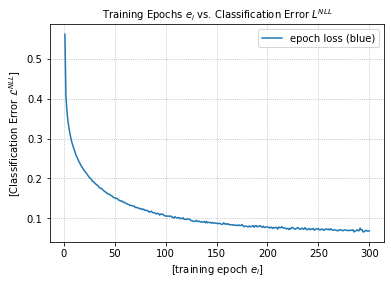

In [156]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

#Load Best model NN 1

In [157]:
# restore pre-trained model snapshot
best_model_name = "model1_epoch_99.pth"

# init pre-trained model class
best_model = MNISTNet()

# load pre-trained models
best_model.load_state_dict(torch.load(os.path.join("models", best_model_name), map_location='cpu'))

<All keys matched successfully>

In [158]:
# set model in evaluation mode
best_model.eval()

MNISTNet(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=300, out_features=150, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=150, out_features=50, bias=True)
  (relu3): ReLU(inplace=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)

In [0]:
eval_dataloader = torch.utils.data.DataLoader(reshaped_eval_dataset, batch_size=10000, shuffle=True)

In [160]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(eval_dataloader):

    # run forward pass through the network
    output = best_model(images)

    # determine classification loss
    loss = nll_loss(output, labels.long())

    # collect mini-batch reconstruction loss
    eval_mini_batch_losses.append(loss.data.item())

# determine mean min-batch loss of epoch
eval_loss = np.mean(eval_mini_batch_losses)

# print epoch loss
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20200508-04:05:56] eval-loss: 0.32967931032180786


In [0]:
predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)

In [162]:
metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach())

0.8964

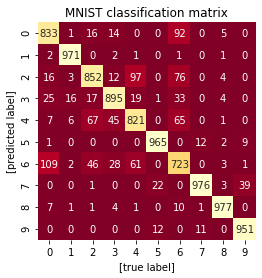

In [163]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(reshaped_eval_dataset.tensors[1], predictions.detach())

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=range(0,10), yticklabels=range(0,10))
plt.title('MNIST classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

In [0]:
# restore pre-trained model snapshot
best_model_numbers = list(range(0,num_epochs,10))

test_results_1 = []

for best_model_number in best_model_numbers:

  temp_results = [best_model_number]

  # init pre-trained model class
  best_model = MNISTNet()

  # load pre-trained models
  best_model.load_state_dict(torch.load(os.path.join("models", "model1_epoch_{}.pth".format(best_model_number)), map_location='cpu'))

  # init collection of mini-batch losses
  eval_mini_batch_losses = []

  # iterate over all-mini batches
  for i, (images, labels) in enumerate(eval_dataloader):

      # run forward pass through the network
      output = best_model(images)

      # determine classification loss
      loss = nll_loss(output, labels.long())

      # collect mini-batch reconstruction loss
      eval_mini_batch_losses.append(loss.data.item())

  # determine mean min-batch loss of epoch
  eval_loss = np.mean(eval_mini_batch_losses)

  temp_results.append(eval_loss)

  predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)

  temp_results.append(metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach()))

  test_results_1.append(temp_results)
  

In [165]:
for test_result in test_results_1:
  print("Epoch {}: Loss = {} and Accuracy = {}".format(test_result[0],test_result[1], test_result[2]))

Epoch 0: Loss = 0.4826904833316803 and Accuracy = 0.8308
Epoch 10: Loss = 0.3408813178539276 and Accuracy = 0.8763
Epoch 20: Loss = 0.3363274037837982 and Accuracy = 0.8794
Epoch 30: Loss = 0.31655359268188477 and Accuracy = 0.8872
Epoch 40: Loss = 0.33505508303642273 and Accuracy = 0.884
Epoch 50: Loss = 0.32627615332603455 and Accuracy = 0.8922
Epoch 60: Loss = 0.31400981545448303 and Accuracy = 0.8979
Epoch 70: Loss = 0.31244760751724243 and Accuracy = 0.8991
Epoch 80: Loss = 0.35249951481819153 and Accuracy = 0.8853
Epoch 90: Loss = 0.3436533212661743 and Accuracy = 0.8939
Epoch 100: Loss = 0.3598005175590515 and Accuracy = 0.8942
Epoch 110: Loss = 0.32619208097457886 and Accuracy = 0.8992
Epoch 120: Loss = 0.35411158204078674 and Accuracy = 0.8912
Epoch 130: Loss = 0.35003411769866943 and Accuracy = 0.8918
Epoch 140: Loss = 0.3477959930896759 and Accuracy = 0.898
Epoch 150: Loss = 0.3619327247142792 and Accuracy = 0.8897
Epoch 160: Loss = 0.42853036522865295 and Accuracy = 0.868
E

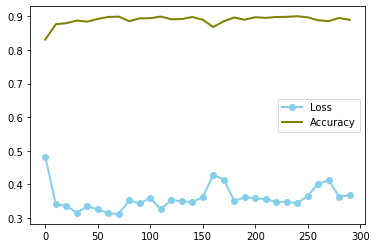

In [167]:
test_results_1 = pd.DataFrame(test_results)
# multiple line plot
plt.plot( test_results_1.iloc[:,0], test_results_1.iloc[:,1], marker='o', color='skyblue', linewidth=2,label="Loss")
plt.plot( test_results_1.iloc[:,0], test_results_1.iloc[:,2], marker='', color='olive', linewidth=2, label="Accuracy")
plt.legend()


In [0]:
test_results # 100 instead of 150

#Neural Network 2

In [0]:
# implement the MNISTNet network architecture
class MNISTNet2(nn.Module):
    
    # define the class constructor
    def __init__(self,layer_):
        
        # call super class constructor
        super(MNISTNet, self).__init__()
        
        # specify fully-connected (fc) layer 1 - in 28*28, out 300
        self.linear1 = nn.Linear(28*28, 300, bias=True) # the linearity W*x+b
        self.relu1 = nn.ReLU(inplace=True) # the non-linearity 
        
        # specify fc layer 2 - in 300, out 150
        self.linear2 = nn.Linear(300, 150, bias=True) # the linearity W*x+b
        self.relu2 = nn.ReLU(inplace=True) # the non-linarity
        
        # specify fc layer 3 - in 100, out 50
        self.linear3 = nn.Linear(150, 50) # the linearity W*x+b
        self.relu3 = nn.ReLU(inplace=True) # the non-linarity

        # specify fc layer 3 - in 50, out 10
        self.linear4 = nn.Linear(50, 10) # the linearity W*x+b
        
        # add a softmax to the last layer
        self.logsoftmax = nn.LogSoftmax(dim=1) # the softmax
        
    # define network forward pass
    def forward(self, images):
        
        # reshape image pixels
        x = images.view(-1, 28*28)
        
        # define fc layer 1 forward pass
        x = self.relu1(self.linear1(x))
        
        # define fc layer 2 forward pass
        x = self.relu2(self.linear2(x))

        # define fc layer 3 forward pass
        x = self.relu3(self.linear3(x))
        
        # define layer 4 forward pass
        x = self.logsoftmax(self.linear4(x))
        
        # return forward pass result
        return x

In [0]:
model = MNISTNet()

In [0]:
# case: gpu computing enabled
if use_gpu == True:
  
  # push model to the GPU
  model = model.cuda()

In [172]:
# print the initialized architectures
print('[LOG] MNISTNet architecture:\n\n{}\n'.format(model))

[LOG] MNISTNet architecture:

MNISTNet(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU(inplace=True)
  (linear2): Linear(in_features=300, out_features=150, bias=True)
  (relu2): ReLU(inplace=True)
  (linear3): Linear(in_features=150, out_features=50, bias=True)
  (relu3): ReLU(inplace=True)
  (linear4): Linear(in_features=50, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)



In [173]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained MNISTNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained MNISTNet model parameters: 288710.


In [0]:
# define the optimization criterion / loss function
crossen_loss = nn.CrossEntropyLoss()

In [0]:
# case: gpu computing enabled
if use_gpu == True:
  
  # push the loss calculation to the GPU
  crossen_loss = crossen_loss.cuda()

In [0]:
# specify the training parameters
num_epochs = 300 # number of training epochs
mini_batch_size = 32 # size of the mini-batches

# define learning rate and optimization strategy
learning_rate = 0.001
decay_rate = 0.01
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, weight_decay = decay_rate)

In [0]:
train_dataloader = torch.utils.data.DataLoader(reshaped_train_dataset, batch_size=mini_batch_size, shuffle=True)

In [178]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
model.train()

# train the MNISTNet model
for epoch in range(num_epochs):
    
    # init collection of mini-batch losses
    train_mini_batch_losses = []
    
    # iterate over all-mini batches
    for i, (images, labels) in enumerate(train_dataloader):
        
        # case: gpu computing enabled
        if use_gpu == True:

          # convert images and labels to cuda tensor
          images = images.cuda()
          labels = labels.cuda()
        
        # run forward pass through the network
        output = model(images)
        
        # reset graph gradients
        model.zero_grad()
        # print(labels)
        # print(type(labels))
        # determine classification loss
        loss = nll_loss(output, labels.long())
        
        # run backward pass
        loss.backward()
        
        # update network paramaters
        optimizer.step()
        
        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())
    
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # save model to local directory
    model_name = 'model1_epoch_{}.pth'.format(str(epoch))
    torch.save(model.state_dict(), os.path.join("./models", model_name))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)

[LOG 20200508-04:14:58] epoch: 0 train-loss: 0.5710244654258092
[LOG 20200508-04:15:03] epoch: 1 train-loss: 0.4112020977218946
[LOG 20200508-04:15:07] epoch: 2 train-loss: 0.3705672471165657
[LOG 20200508-04:15:12] epoch: 3 train-loss: 0.34616055295070014
[LOG 20200508-04:15:16] epoch: 4 train-loss: 0.3267797087152799
[LOG 20200508-04:15:21] epoch: 5 train-loss: 0.31320461543401085
[LOG 20200508-04:15:25] epoch: 6 train-loss: 0.2999264262954394
[LOG 20200508-04:15:30] epoch: 7 train-loss: 0.29134674894014995
[LOG 20200508-04:15:35] epoch: 8 train-loss: 0.281937916747729
[LOG 20200508-04:15:39] epoch: 9 train-loss: 0.2731676293174426
[LOG 20200508-04:15:44] epoch: 10 train-loss: 0.26580405756632486
[LOG 20200508-04:15:49] epoch: 11 train-loss: 0.25923898249467214
[LOG 20200508-04:15:53] epoch: 12 train-loss: 0.25401591458121936
[LOG 20200508-04:15:58] epoch: 13 train-loss: 0.24930272748072943
[LOG 20200508-04:16:02] epoch: 14 train-loss: 0.24330450288852057
[LOG 20200508-04:16:07] epoc

In [0]:
# restore pre-trained model snapshot
best_model_numbers = list(range(0,num_epochs,10))

test_results_2 = []

for best_model_number in best_model_numbers:

  temp_results = [best_model_number]

  # init pre-trained model class
  best_model = MNISTNet()

  # load pre-trained models
  best_model.load_state_dict(torch.load(os.path.join("models", "model1_epoch_{}.pth".format(best_model_number)), map_location='cpu'))

  # init collection of mini-batch losses
  eval_mini_batch_losses = []

  # iterate over all-mini batches
  for i, (images, labels) in enumerate(eval_dataloader):

      # run forward pass through the network
      output = best_model(images)

      # determine classification loss
      loss = nll_loss(output, labels.long())

      # collect mini-batch reconstruction loss
      eval_mini_batch_losses.append(loss.data.item())

  # determine mean min-batch loss of epoch
  eval_loss = np.mean(eval_mini_batch_losses)

  temp_results.append(eval_loss)

  predictions = torch.argmax(best_model(reshaped_eval_dataset.tensors[0].float()), dim=1)

  temp_results.append(metrics.accuracy_score(reshaped_eval_dataset.tensors[1], predictions.detach()))

  test_results_2.append(temp_results)
  

In [180]:
for test_result in test_results_2:
  print("Epoch {}: Loss = {} and Accuracy = {}".format(test_result[0],test_result[1], test_result[2]))

Epoch 0: Loss = 0.4589300751686096 and Accuracy = 0.8386
Epoch 10: Loss = 0.38023287057876587 and Accuracy = 0.8606
Epoch 20: Loss = 0.31654825806617737 and Accuracy = 0.8867
Epoch 30: Loss = 0.3385959267616272 and Accuracy = 0.8783
Epoch 40: Loss = 0.30980411171913147 and Accuracy = 0.8915
Epoch 50: Loss = 0.337934285402298 and Accuracy = 0.8902
Epoch 60: Loss = 0.32250237464904785 and Accuracy = 0.8952
Epoch 70: Loss = 0.31908145546913147 and Accuracy = 0.8941
Epoch 80: Loss = 0.34589508175849915 and Accuracy = 0.8903
Epoch 90: Loss = 0.33721432089805603 and Accuracy = 0.893
Epoch 100: Loss = 0.36002472043037415 and Accuracy = 0.8857
Epoch 110: Loss = 0.3540275990962982 and Accuracy = 0.8904
Epoch 120: Loss = 0.3510270118713379 and Accuracy = 0.8927
Epoch 130: Loss = 0.4005017578601837 and Accuracy = 0.8774
Epoch 140: Loss = 0.34475967288017273 and Accuracy = 0.8952
Epoch 150: Loss = 0.36947572231292725 and Accuracy = 0.8913
Epoch 160: Loss = 0.3635197579860687 and Accuracy = 0.891
E

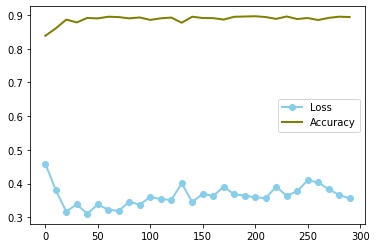

In [181]:
test_results_2 = pd.DataFrame(test_results_2)
# multiple line plot
plt.plot( test_results_2.iloc[:,0], test_results_2.iloc[:,1], marker='o', color='skyblue', linewidth=2,label="Loss")
plt.plot( test_results_2.iloc[:,0], test_results_2.iloc[:,2], marker='', color='olive', linewidth=2, label="Accuracy")
plt.legend()


In [188]:
test_results_1.iloc[:,0]

0       0
1      10
2      20
3      30
4      40
5      50
6      60
7      70
8      80
9      90
10    100
11    110
12    120
13    130
14    140
15    150
16    160
17    170
18    180
19    190
20    200
21    210
22    220
23    230
24    240
25    250
26    260
27    270
28    280
29    290
Name: 0, dtype: int64

In [189]:
for test_result in range(len(test_results_1)):
  print("At Epoch {} - NLL Accuracy = {} , Cross-Entropy = {}".format(test_results_1.iloc[test_result,0],test_results_1.iloc[test_result,2], test_results_2.iloc[test_result,2]))

At Epoch 0 - NLL Accuracy = 0.8308 , Cross-Entropy = 0.8386
At Epoch 10 - NLL Accuracy = 0.8763 , Cross-Entropy = 0.8606
At Epoch 20 - NLL Accuracy = 0.8794 , Cross-Entropy = 0.8867
At Epoch 30 - NLL Accuracy = 0.8872 , Cross-Entropy = 0.8783
At Epoch 40 - NLL Accuracy = 0.884 , Cross-Entropy = 0.8915
At Epoch 50 - NLL Accuracy = 0.8922 , Cross-Entropy = 0.8902
At Epoch 60 - NLL Accuracy = 0.8979 , Cross-Entropy = 0.8952
At Epoch 70 - NLL Accuracy = 0.8991 , Cross-Entropy = 0.8941
At Epoch 80 - NLL Accuracy = 0.8853 , Cross-Entropy = 0.8903
At Epoch 90 - NLL Accuracy = 0.8939 , Cross-Entropy = 0.893
At Epoch 100 - NLL Accuracy = 0.8942 , Cross-Entropy = 0.8857
At Epoch 110 - NLL Accuracy = 0.8992 , Cross-Entropy = 0.8904
At Epoch 120 - NLL Accuracy = 0.8912 , Cross-Entropy = 0.8927
At Epoch 130 - NLL Accuracy = 0.8918 , Cross-Entropy = 0.8774
At Epoch 140 - NLL Accuracy = 0.898 , Cross-Entropy = 0.8952
At Epoch 150 - NLL Accuracy = 0.8897 , Cross-Entropy = 0.8913
At Epoch 160 - NLL Acc

Add regularization (E.g. dropout) <br>
Try different optimization algorithm
- L-BFGS
- Conjugate gradient<br>
Try Cross-entropy loss function
Try Leaky Relu
Look into dropout layer for regularization